In [1]:
import os
import numpy as np
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sys
sys.path.append("../../utilities/")
import data_utils
import evaluation_utils
import seaborn as sns
import umap
import math
from sklearn import metrics
from matplotlib import pyplot as plt
sys.path.append("../../src")
from dataset_class import dataset
from importlib import reload
evaluation_utils = reload(evaluation_utils)

In [3]:
GM12878_signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
GM12878_dataset = dataset('GM12878', 'hg19', 100000, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res100000',
                 GM12878_signals_names, '../../data/GM12878/hg19/genomic-assays/bin_100000/', 
                  '../../data/GM12878/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
GM12878_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_100000_bins.txt')

In [56]:
resolution = 100000
gene_expression_path = '../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt'
RT_path = '../../data/GM12878/hg19/RT/six_phase/six_phases.txt'
GMM_annotations_dir = '../../data/GM12878/hg19/res100000_datasets/annotations/GMM/'
HMM_annotations_dir = '../../data/GM12878/hg19/res100000_datasets/annotations/HMM/'
KMeans_annotations_dir = '../../data/GM12878/hg19/res100000_datasets/annotations/KMeans/'
segway_annotations_dir = '../../data/GM12878/hg19/res100000_datasets/annotations/Segway/'
functional_signals_path = '../../data/GM12878/hg19/res100000_datasets/signals.txt'
functional_signals = np.loadtxt(functional_signals_path)

In [47]:
GM12878_dataset.read_segway_annotation('../../experiments/Segway/annotdir_res100000_k4/segway.bed.gz', 'segway_k4')
GM12878_dataset.read_segway_annotation('../../experiments/Segway/annotdir_res100000_k5/segway.bed.gz', 'segway_k5')

In [48]:
GM12878_dataset.write_annotation(GM12878_dataset.labels['segway_k4'], 'segway_k4', 
                                 '../../data/GM12878/hg19/res100000_datasets/annotations/Segway')
GM12878_dataset.write_annotation(GM12878_dataset.labels['segway_k5'], 'segway_k5', 
                                 '../../data/GM12878/hg19/res100000_datasets/annotations/Segway')

In [50]:
GM12878_dataset.write_annotation(functional_HMM_viterbi_labels['HMM_viterbi_4'].values, 'HMM_k4', 
                                 '../../data/GM12878/hg19/res100000_datasets/annotations/HMM')
GM12878_dataset.write_annotation(functional_HMM_viterbi_labels['HMM_viterbi_5'].values, 'HMM_k5', 
                                 '../../data/GM12878/hg19/res100000_datasets/annotations/HMM')

In [28]:
k4_annotations = pd.DataFrame()
k4_annotations['kmeans'] = functional_kmeans_labels['kmeans_4'].values
k4_annotations['GMM'] = functional_GMM_labels['GMM_4'].values
k4_annotations['HMM'] = functional_HMM_viterbi_labels['HMM_viterbi_4'].values
k4_annotations['segway'] = GM12878_dataset.labels['segway_k4']

In [29]:
ARI_df = pd.DataFrame(index = k4_annotations.columns, columns = k4_annotations.columns)
for i, method1 in enumerate(k4_annotations.columns):
    for method2 in k4_annotations.columns[i:]:
        ARI = metrics.adjusted_rand_score(k4_annotations.dropna()[method1], k4_annotations.dropna()[method2])
        ARI_df.loc[method1,method2] = ARI

In [59]:
ARI_df

,kmeans,GMM,HMM,segway
kmeans,1,0.349402,0.487665,0.36008
GMM,NaN,1,0.565963,0.371124
HMM,NaN,NaN,1,0.372951
segway,NaN,NaN,NaN,1


In [93]:
np.unique(k4_annotations.dropna()['GMM'], return_counts = True)

(array([0, 1, 2, 3]), array([ 5838,  4103, 10252,  6502]))

In [35]:
k4_annotations[GM12878_signals_names] = functional_signals

In [40]:
WSS = {}
for method in ['kmeans', 'GMM', 'HMM', 'segway']:
    WSS[method] = evaluation_utils.within_cluster_SSE(k4_annotations.dropna()[GM12878_signals_names].values
                                                      ,k4_annotations.dropna()[method].values)

Text(0, 0.5, 'Within Sum of Squared (WSS)')

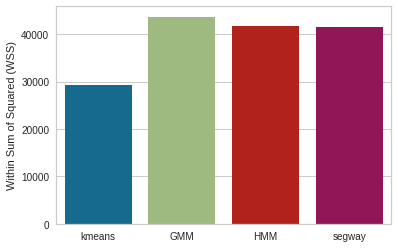

In [76]:
ax = sns.barplot(x=list(WSS.keys()), y=list(WSS.values()))
ax.set_ylabel('Within Sum of Squared (WSS)')

In [61]:
num_domains = {}
for method in ['kmeans', 'GMM', 'HMM', 'segway']:
    num_domains[method] = evaluation_utils.num_domains(k4_annotations.dropna()[method].values)

In [79]:
domains_length = {}
for method in ['kmeans', 'GMM', 'HMM', 'segway']:
    domains_length[method] = evaluation_utils.average_length(k4_annotations.dropna()[method].values, 100000)

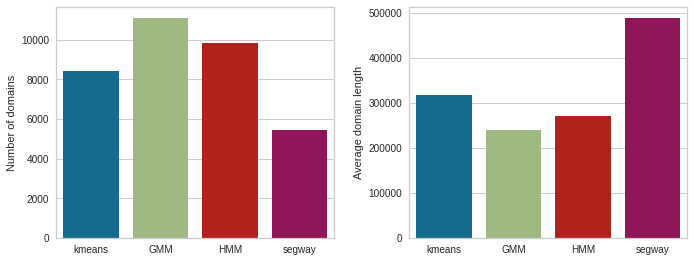

In [84]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
sns.barplot(x=list(num_domains.keys()), y=list(num_domains.values()), ax = axs[0])
axs[0].set_ylabel('Number of domains')
sns.barplot(x=list(domains_length.keys()), y=list(domains_length.values()), ax = axs[1])
axs[1].set_ylabel('Average domain length')
fig.tight_layout(pad=2.0)

In [57]:
gene_expression_ve = {}
gene_expression_ve['kmeans'] = evaluation_utils.gene_expression_ve(gene_expression_path, 
                                                                   os.path.join(KMeans_annotations_dir,
                                                                               'kmeans_4_annotation.txt'),
                                                                  resolution)
gene_expression_ve['GMM'] = evaluation_utils.gene_expression_ve(gene_expression_path, 
                                                                   os.path.join(GMM_annotations_dir,
                                                                               'GMM_4_annotation.txt'),
                                                                  resolution)
gene_expression_ve['HMM'] = evaluation_utils.gene_expression_ve(gene_expression_path, 
                                                                   os.path.join(HMM_annotations_dir,
                                                                               'HMM_k4_annotation.txt'),
                                                                  resolution)
gene_expression_ve['segway'] = evaluation_utils.gene_expression_ve(gene_expression_path, 
                                                                   os.path.join(segway_annotations_dir,
                                                                               'segway_k4_annotation.txt'),
                                                                  resolution)

Text(0, 0.5, 'Gene expression VE')

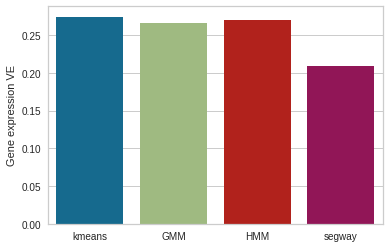

In [85]:
ax = sns.barplot(x=list(gene_expression_ve.keys()), y=list(gene_expression_ve.values()))
ax.set_ylabel('Gene expression VE')

In [65]:
RT_scores = {}
RT_scores['kmeans'] = evaluation_utils.RT_scores(RT_path, os.path.join(KMeans_annotations_dir,
                                                                               'kmeans_4_annotation.txt'),
                                                                  resolution)
RT_scores['GMM'] = evaluation_utils.RT_scores(RT_path, os.path.join(GMM_annotations_dir,
                                                                               'GMM_4_annotation.txt'),
                                                                  resolution)
RT_scores['HMM'] = evaluation_utils.RT_scores(RT_path, os.path.join(HMM_annotations_dir,
                                                                               'HMM_k4_annotation.txt'),
                                                                  resolution)
RT_scores['segway'] = evaluation_utils.RT_scores(RT_path, os.path.join(segway_annotations_dir,
                                                                               'segway_k4_annotation.txt'),
                                                                  resolution)

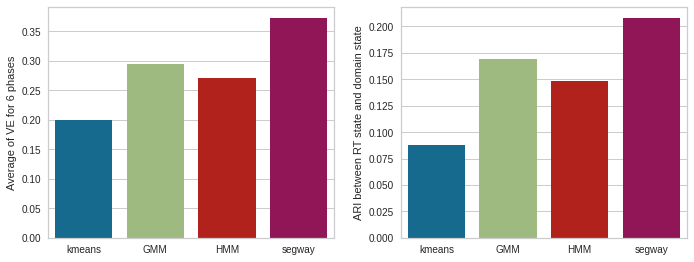

In [91]:
score1 = [s[0] for s in list(RT_scores.values())]
score2 = [s[1] for s in list(RT_scores.values())]
fig, axs = plt.subplots(1,2, figsize = (10,4))
sns.barplot(x=list(RT_scores.keys()), y=score1, ax = axs[0])
axs[0].set_ylabel('Average of VE for 6 phases')
sns.barplot(x=list(RT_scores.keys()), y=score2, ax = axs[1])
axs[1].set_ylabel('ARI between RT state and domain state')
fig.tight_layout(pad=2.0)

In [12]:
functional_umap = umap.UMAP().fit_transform(functional_signals)
functional_df = pd.DataFrame(functional_signals)
functional_df.columns = GM12878_signals_names
functional_df = pd.concat([functional_df, pd.DataFrame({'umap1': functional_umap[:,0], 'umap2': functional_umap[:,1]})], axis = 1)

In [7]:
functional_GMM_labels = pd.read_csv('results/GMM_res100000.txt', sep = '\t')
functional_kmeans_labels = pd.read_csv('results/kmeans_res100000.txt', sep = '\t')
functional_HMM_viterbi_labels = pd.read_csv('results/HMM_viterbi_res100000.txt', sep = "\t")

In [31]:
functional_kmeans_CH = []
functional_GMM_CH = []
for k in np.arange(2,16):
    functional_GMM_CH.append(metrics.calinski_harabasz_score(functional_signals, functional_GMM_labels['GMM_{}'.format(k)]))
    functional_kmeans_CH.append(metrics.calinski_harabasz_score(functional_signals, functional_kmeans_labels['kmeans_{}'.format(k)]))

In [46]:
functional_kmeans_WSS = []
functional_GMM_WSS = []
functional_HMM_virtebi_WSS = []
for k in np.arange(2,16):
    functional_GMM_WSS.append(evaluation_utils.within_cluster_SSE(functional_signals, functional_GMM_labels['GMM_{}'.format(k)]))
    functional_kmeans_WSS.append(evaluation_utils.within_cluster_SSE(functional_signals, functional_kmeans_labels['kmeans_{}'.format(k)]))
    functional_HMM_virtebi_WSS.append(evaluation_utils.within_cluster_SSE(functional_signals, functional_HMM_viterbi_labels['HMM_viterbi_{}'.format(k)]))

<AxesSubplot:>

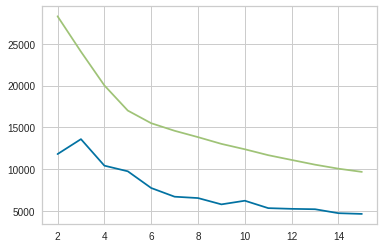

In [33]:
sns.lineplot(x=np.arange(2,16), y=functional_GMM_CH)
sns.lineplot(x=np.arange(2,16), y=functional_kmeans_CH)
# since the pattern is not really separable, variance criterion ratio is not getting higher??

<AxesSubplot:>

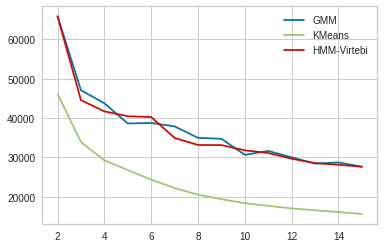

In [48]:
sns.lineplot(x=np.arange(2,16), y=functional_GMM_WSS, label = 'GMM')
sns.lineplot(x=np.arange(2,16), y=functional_kmeans_WSS, label = 'KMeans')
sns.lineplot(x=np.arange(2,16), y=functional_HMM_virtebi_WSS, label = 'HMM-Virtebi')

In [52]:
HMM_viterbi_num_domains = []
for k in np.arange(2,16):
    HMM_viterbi_num_domains.append(num_domains(functional_HMM_viterbi_labels['HMM_viterbi_{}'.format(k)]))

In [53]:
HMM_viterbi_num_domains

[4813,
 8435,
 9831,
 10431,
 11083,
 11796,
 12260,
 12243,
 12151,
 12449,
 12536,
 12516,
 13054,
 12997]

In [39]:
GMM_num_domains = []
for k in np.arange(2,16):
    annotation_path = os.path.join(GMM_annotations_dir, 'GMM_{}_annotation.txt'.format(k))
    GMM_num_domains.append(pd.read_csv(annotation_path, sep = "\t", header = None).shape[0])

In [43]:
kmeans_num_domains = []
for k in np.arange(2,16):
    annotation_path = os.path.join(KMeans_annotations_dir, 'kmeans_{}_annotation.txt'.format(k))
    kmeans_num_domains.append(pd.read_csv(annotation_path, sep = "\t", header = None).shape[0])

In [44]:
kmeans_num_domains

[4644,
 6944,
 8562,
 8941,
 10584,
 11124,
 12554,
 12638,
 13278,
 13546,
 13647,
 14647,
 14768,
 14809]

In [41]:
GMM_num_domains

[5122,
 9222,
 11199,
 12403,
 12963,
 13755,
 14713,
 15193,
 15623,
 15981,
 15839,
 16238,
 16477,
 16168]

In [19]:
structural_df = pd.DataFrame(structural_signals)
structural_df.columns = ['emb{}'.format(e) for e in np.arange(1,9)]
structural_df = pd.concat([structural_df, pd.DataFrame({'umap1': structural_umap[:,0], 'umap2': structural_umap[:,1]})], axis = 1)